In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, make_FP_axs, same_stim_trial, take_names, get_filename
from tools_lnd import gen_X_from_model_dir_epoch, gen_trials_from_model_dir, gen_X_from_model_dir

In [4]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','review_new_figs','fp_dst_subspaces')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [5]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/'


In [21]:
from tools_lnd import make_D_use, take_names, gen_mov_trial_set, gen_D_fp_qr, gen_stim_trial_set

# CAT SUBSPACE
interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

axs = 'pca_h_cat'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_stim_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

epoch_set = ['stim1','stim1']
rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule_str, epoch_set[0], axs = axs)

D_use = -D_stim
D_use[:,2] = D_fp_qr[:,0]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2',
             epoch_name_ax+' State PC3']

script_name = 'interp_tasks_small_init_stim'
epoch_set = ['stim1','stim1']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [97]:
from tools_lnd import vanilla_run_with_h0, get_interp_filename, find_closest_fp_loc


def find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, q_thresh = 1e-6, q_tol_name = 'tol_q_e_6.0',script_name = 'interp_tasks_small_init_mov'):

    n_interp = 20
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp

    T_inds = get_T_inds(trial_set[0],epoch_set[0])
    inputs_1 = trial_set[0].x[0:T_inds[-1],trial_num[0],:]
    inputs_2 = trial_set[1].x[0:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    rel_fp_loc = [None]*n_interp
    w_in = [None]*n_interp
    w_out = [None]*n_interp

    diff_rel_fp = [None]*n_interp
    diff_rel_fp_in = [None]*n_interp
    diff_rel_fp_out = [None]*n_interp

    _,x = gen_X_from_model_dir(m,trial_set[0])
    h_epoch = np.transpose(x[:,:,0:],(1,2,0))

    for step_i in range(n_interp):

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[0],0,:]

        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

        f = get_interp_filename(trial_set[0],trial_set[1],epoch_set,trial_num)
        save_dir = os.path.join(m,script_name,'_'.join([rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]

        rel_fp, rel_fp_loc[step_i] = find_closest_fp_loc(h_t[-1,:],fp_struct['xstar'][fp_inds,:])
        w_in[step_i] = np.dot(D_stim[:,:2].T,rel_fp_loc[step_i])
        w_out[step_i] = np.dot(D_stim[:,2:].T,rel_fp_loc[step_i])

        if step_i>0:
            diff_rel_fp[step_i] = LA.norm(rel_fp_loc[step_i] - rel_fp_loc[step_i-1])
            diff_rel_fp_in[step_i] = LA.norm(w_in[step_i] - w_in[step_i-1])
            diff_rel_fp_out[step_i] = LA.norm(w_out[step_i] - w_out[step_i-1])

    return diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out

In [119]:
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]
axs = 'pca_h'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_stim_trial_set(m,rule_set)

script_name = 'interp_tasks_small_init_mov'
epoch_set = ['fix1','fix1']
rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule, epoch_set[0], axs = axs, n_components = 256)
D_use = D_stim

diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

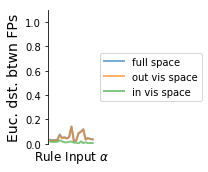

In [120]:
fig = plt.figure(figsize=(3,2.5),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

al = .6
lw = 2
plt.plot(diff_rel_fp,alpha = al,lw = lw,label = 'full space')
plt.plot(diff_rel_fp_out,alpha = al,lw = lw,label = 'out vis space')
plt.plot(diff_rel_fp_in,alpha = al,lw = lw,label = 'in vis space')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim([0,1.1])
plt.ylabel('Euc. dst. btwn FPs',fontsize = 14)
plt.xlabel(r"Rule Input $\alpha$",fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])


plt.show()

In [121]:
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]
axs = 'pca_h'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_stim_trial_set(m,rule_set)

script_name = 'interp_tasks_small_init_stim'
epoch_set = ['stim1','stim1']
rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule, epoch_set[0], axs = axs, n_components = 256)
D_use = D_stim

diff_rel_fp, diff_rel_fp_in, diff_rel_fp_out = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, script_name = script_name)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

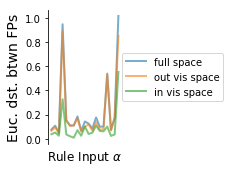

In [129]:
fig = plt.figure(figsize=(3.2,2.5),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

al = .6
lw = 2
plt.plot(diff_rel_fp,alpha = al,lw = lw,label = 'full space')
plt.plot(diff_rel_fp_out,alpha = al,lw = lw,label = 'out vis space')
plt.plot(diff_rel_fp_in,alpha = al,lw = lw,label = 'in vis space')
ax.legend(loc='center left', bbox_to_anchor=(.93, 0.5))

# plt.ylim([0,1])
plt.ylabel('Euc. dst. btwn FPs',fontsize = 14)
plt.xlabel(r"Rule Input $\alpha$",fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])


plt.show()